# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

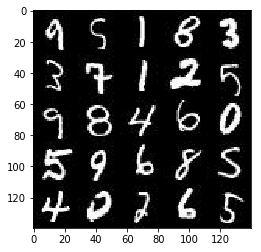

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

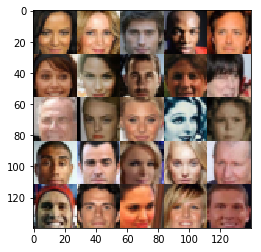

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) ,name='images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Convolutional layers
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        norm2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*norm2, norm2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        norm3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*norm3, norm3)
        # 4x4x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)                

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        full = tf.layers.dense(z, 7*7*512)
        
        #Convolutional layers
        x1 = tf.reshape(full, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*norm1, norm1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        norm2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*norm2, norm2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        norm3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 =tf.maximum(alpha*norm3, norm3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 12.1339
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 1.2254
Epoch 1/2... Discriminator Loss: 2.1987... Generator Loss: 0.1692
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 1.9347... Generator Loss: 0.2355
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.2846
Epoch 1/2... Discriminator Loss: 1.9134... Generator Loss: 0.1981
Epoch 1/2... Discriminator Loss: 2.6433... Generator Loss: 0.0878


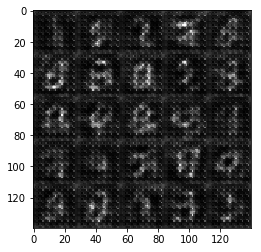

Epoch 1/2... Discriminator Loss: 0.3787... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.0494
Epoch 1/2... Discriminator Loss: 0.0749... Generator Loss: 3.6221
Epoch 1/2... Discriminator Loss: 0.0255... Generator Loss: 5.1260
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 2.9410... Generator Loss: 5.1722
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 2.1300... Generator Loss: 0.1578


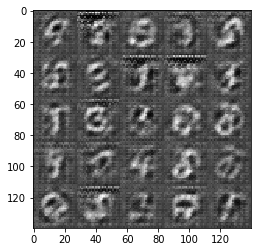

Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 2.6487
Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 1.3535
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 4.6957
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 5.6748
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 0.4894... Generator Loss: 1.8827
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 0.1283... Generator Loss: 2.5598


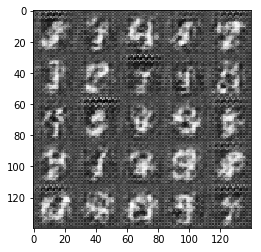

Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 0.1510... Generator Loss: 2.6770
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 3.7728
Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 4.9163
Epoch 1/2... Discriminator Loss: 0.2058... Generator Loss: 2.2178
Epoch 1/2... Discriminator Loss: 0.2481... Generator Loss: 1.8952
Epoch 1/2... Discriminator Loss: 0.0563... Generator Loss: 7.5022
Epoch 1/2... Discriminator Loss: 0.2927... Generator Loss: 1.5773


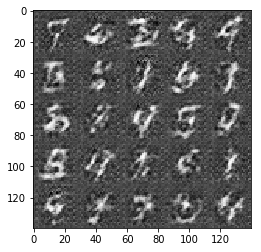

Epoch 1/2... Discriminator Loss: 2.0357... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 2.5376... Generator Loss: 0.1257
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 2.3486... Generator Loss: 3.3225
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 3.0465
Epoch 1/2... Discriminator Loss: 0.1947... Generator Loss: 3.4803
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 1.4369
Epoch 1/2... Discriminator Loss: 0.7645... Generator Loss: 2.4640


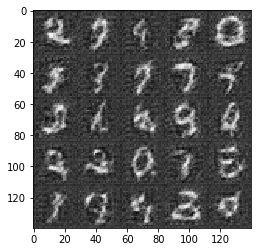

Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 0.6306
Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 2.1178
Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 5.6757
Epoch 1/2... Discriminator Loss: 0.2181... Generator Loss: 1.8911
Epoch 1/2... Discriminator Loss: 0.0213... Generator Loss: 5.3584
Epoch 1/2... Discriminator Loss: 0.0539... Generator Loss: 4.3550
Epoch 1/2... Discriminator Loss: 0.2105... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 0.0356... Generator Loss: 6.9164
Epoch 1/2... Discriminator Loss: 0.0218... Generator Loss: 4.5212
Epoch 1/2... Discriminator Loss: 0.1165... Generator Loss: 2.6128


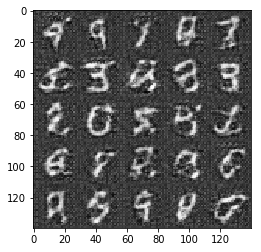

Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.7161... Generator Loss: 2.9110
Epoch 1/2... Discriminator Loss: 2.2779... Generator Loss: 0.1463
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 2.1523... Generator Loss: 0.1599
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.8619... Generator Loss: 0.2510
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 1.4778
Epoch 1/2... Discriminator Loss: 0.0666... Generator Loss: 3.3639


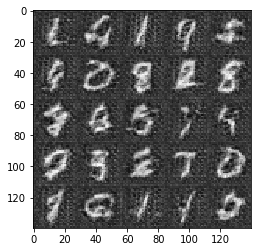

Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 3.3255
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.8617
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 2.7920
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 1.3594
Epoch 1/2... Discriminator Loss: 0.0577... Generator Loss: 3.8797
Epoch 1/2... Discriminator Loss: 0.0603... Generator Loss: 4.0545
Epoch 1/2... Discriminator Loss: 0.0955... Generator Loss: 2.7371
Epoch 1/2... Discriminator Loss: 0.0767... Generator Loss: 2.8863
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 6.8358
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 6.6190


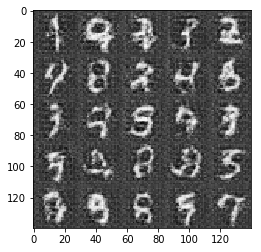

Epoch 1/2... Discriminator Loss: 0.0440... Generator Loss: 3.5578
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 2.3788
Epoch 1/2... Discriminator Loss: 0.1303... Generator Loss: 2.4347
Epoch 1/2... Discriminator Loss: 0.6950... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 0.0468... Generator Loss: 3.5258
Epoch 1/2... Discriminator Loss: 0.0089... Generator Loss: 6.9257
Epoch 1/2... Discriminator Loss: 0.1442... Generator Loss: 2.3422
Epoch 1/2... Discriminator Loss: 0.0113... Generator Loss: 6.0671
Epoch 1/2... Discriminator Loss: 0.0123... Generator Loss: 6.8749
Epoch 1/2... Discriminator Loss: 0.0792... Generator Loss: 2.9185


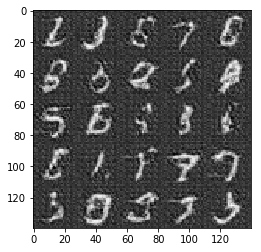

Epoch 1/2... Discriminator Loss: 0.0083... Generator Loss: 6.6668
Epoch 1/2... Discriminator Loss: 0.0354... Generator Loss: 5.9737
Epoch 1/2... Discriminator Loss: 0.3330... Generator Loss: 1.6701
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 1.0712
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 2.3483
Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 2.0183
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.5077
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.0799


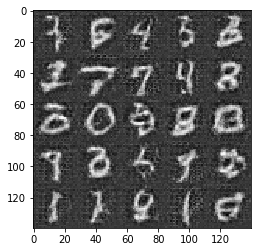

Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.3459
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 0.3293
Epoch 2/2... Discriminator Loss: 1.9626... Generator Loss: 3.5323
Epoch 2/2... Discriminator Loss: 0.8301... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.0380
Epoch 2/2... Discriminator Loss: 1.5715... Generator Loss: 0.3737
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 0.3102... Generator Loss: 1.9206


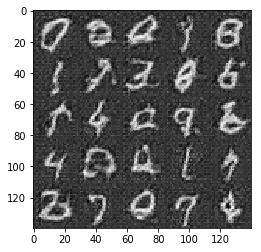

Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 1.5366
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 3.7097
Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.2808
Epoch 2/2... Discriminator Loss: 0.4569... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.2877
Epoch 2/2... Discriminator Loss: 0.4018... Generator Loss: 1.3977
Epoch 2/2... Discriminator Loss: 0.1346... Generator Loss: 2.7264
Epoch 2/2... Discriminator Loss: 0.0698... Generator Loss: 3.5295


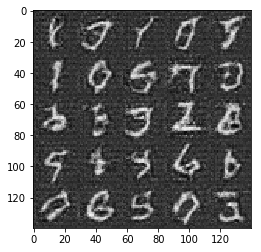

Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 4.2919
Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 4.7945
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 0.2558
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 0.2657... Generator Loss: 2.1371
Epoch 2/2... Discriminator Loss: 0.1156... Generator Loss: 2.7944
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 1.2739
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.2022
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.4193


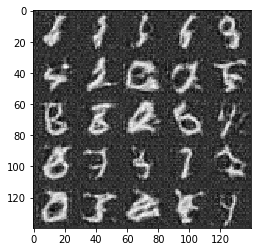

Epoch 2/2... Discriminator Loss: 0.2348... Generator Loss: 2.1028
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 3.2933
Epoch 2/2... Discriminator Loss: 0.2593... Generator Loss: 1.7553
Epoch 2/2... Discriminator Loss: 0.0998... Generator Loss: 2.9547
Epoch 2/2... Discriminator Loss: 0.1075... Generator Loss: 2.7943
Epoch 2/2... Discriminator Loss: 0.0354... Generator Loss: 5.1328
Epoch 2/2... Discriminator Loss: 0.1137... Generator Loss: 2.6291
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 6.3769
Epoch 2/2... Discriminator Loss: 0.2097... Generator Loss: 2.0647
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 0.7795


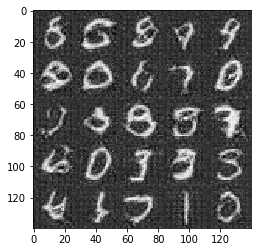

Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 2.8110
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.1182... Generator Loss: 2.9899
Epoch 2/2... Discriminator Loss: 0.0554... Generator Loss: 4.2774
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 3.4275
Epoch 2/2... Discriminator Loss: 0.2628... Generator Loss: 1.8839
Epoch 2/2... Discriminator Loss: 0.2867... Generator Loss: 1.7119
Epoch 2/2... Discriminator Loss: 0.0414... Generator Loss: 4.3014
Epoch 2/2... Discriminator Loss: 0.0971... Generator Loss: 3.0082
Epoch 2/2... Discriminator Loss: 0.0296... Generator Loss: 4.6459


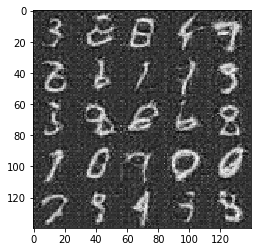

Epoch 2/2... Discriminator Loss: 0.0329... Generator Loss: 5.0909
Epoch 2/2... Discriminator Loss: 0.0203... Generator Loss: 6.1642
Epoch 2/2... Discriminator Loss: 0.1204... Generator Loss: 2.6341
Epoch 2/2... Discriminator Loss: 0.0474... Generator Loss: 3.9586
Epoch 2/2... Discriminator Loss: 0.0167... Generator Loss: 5.6193
Epoch 2/2... Discriminator Loss: 0.0139... Generator Loss: 6.0828
Epoch 2/2... Discriminator Loss: 0.1507... Generator Loss: 2.3767
Epoch 2/2... Discriminator Loss: 0.0116... Generator Loss: 7.1632
Epoch 2/2... Discriminator Loss: 0.1424... Generator Loss: 2.4915
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 7.8378


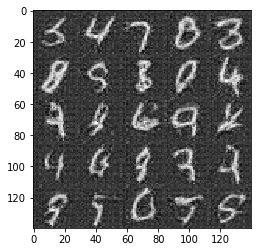

Epoch 2/2... Discriminator Loss: 0.0274... Generator Loss: 4.5642
Epoch 2/2... Discriminator Loss: 0.0064... Generator Loss: 7.1268
Epoch 2/2... Discriminator Loss: 0.0102... Generator Loss: 7.8517
Epoch 2/2... Discriminator Loss: 0.0073... Generator Loss: 6.3322
Epoch 2/2... Discriminator Loss: 0.0063... Generator Loss: 6.7591
Epoch 2/2... Discriminator Loss: 0.0213... Generator Loss: 4.7018
Epoch 2/2... Discriminator Loss: 0.4762... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.7005... Generator Loss: 3.4157
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 4.0258
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 3.6155


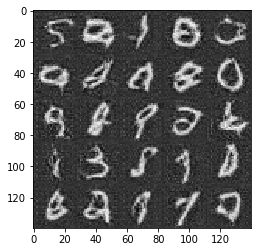

Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 2.0992... Generator Loss: 0.1831
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 3.3354
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.5364
Epoch 2/2... Discriminator Loss: 0.3084... Generator Loss: 1.7629
Epoch 2/2... Discriminator Loss: 2.5799... Generator Loss: 0.1308
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 2.3503... Generator Loss: 0.1771
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.7181


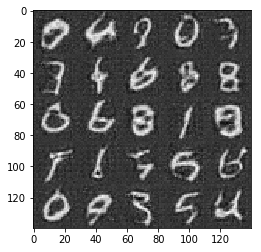

Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 2.3324
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.3588


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3009... Generator Loss: 0.1843
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.8189
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 2.0421


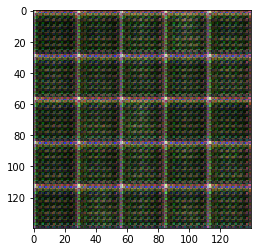

Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.3270
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.4102
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 1.8245


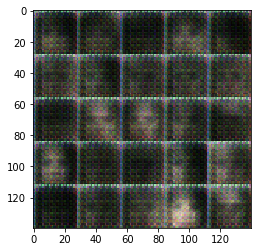

Epoch 1/1... Discriminator Loss: 3.6755... Generator Loss: 0.0334
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 3.8867
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.8526
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 1.5054
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 3.9727
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 4.1609
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 2.5881
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.3965


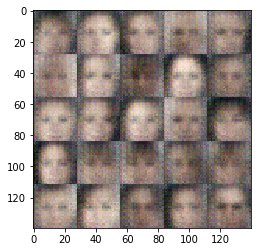

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 2.7320
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 1.9677


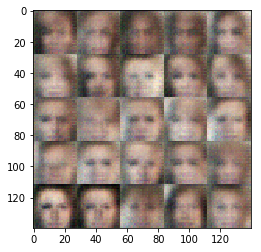

Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.9330
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.3178... Generator Loss: 2.0525
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 2.0746


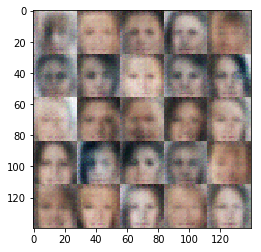

Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.9335
Epoch 1/1... Discriminator Loss: 0.3056... Generator Loss: 2.3214
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 2.9746
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 4.2675
Epoch 1/1... Discriminator Loss: 0.2621... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.3685
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 3.6575
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.2920... Generator Loss: 1.9649


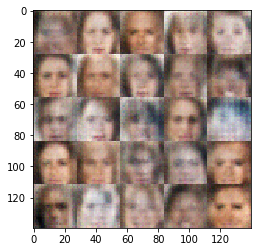

Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 2.9332
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 3.0576
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 3.2752
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 2.8260
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 2.1387
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 0.2093
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.3769


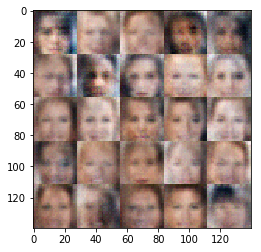

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 3.9701
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 3.8210
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 3.0251
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.8265
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 2.8207
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 3.6151
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 3.4068


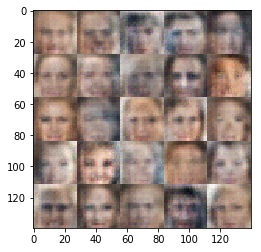

Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 3.4861
Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 2.7113
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 4.0451
Epoch 1/1... Discriminator Loss: 1.7476... Generator Loss: 0.2442
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.3007


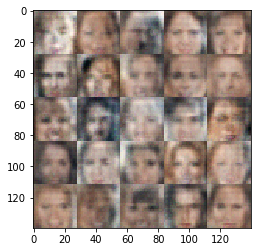

Epoch 1/1... Discriminator Loss: 2.0337... Generator Loss: 0.1893
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 3.4324
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 2.7710
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 3.5919
Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 2.5251
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 2.8440
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.5295
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 4.2275
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 2.5138


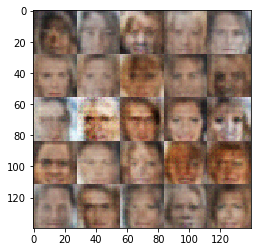

Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 3.1765
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 3.9015
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 3.3866
Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 3.2399
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 4.5047
Epoch 1/1... Discriminator Loss: 0.2999... Generator Loss: 3.8523
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 4.0174
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.0500


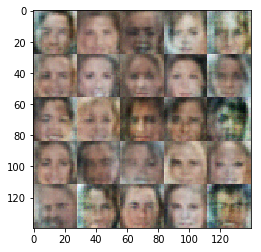

Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.6126
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 5.3207
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 4.1134
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 2.7869
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.2394


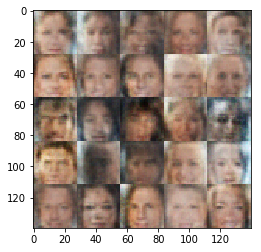

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 3.1633
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 0.1441... Generator Loss: 4.2066


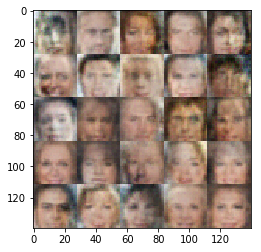

Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 4.2718
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.6806
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 4.7560
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 3.4800
Epoch 1/1... Discriminator Loss: 1.8862... Generator Loss: 0.2011
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 4.0465
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.4642


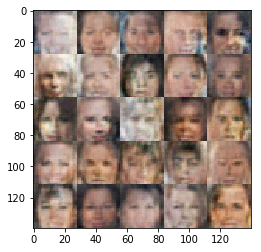

Epoch 1/1... Discriminator Loss: 0.0924... Generator Loss: 5.0014
Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 4.5727
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 3.6170
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 4.9819
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 5.0258
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 4.2523
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.7881
Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 5.0533
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.7590


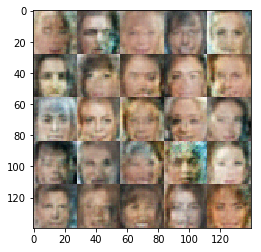

Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 1.6256
Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 3.9061
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 3.9852
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 3.6555
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 6.9300


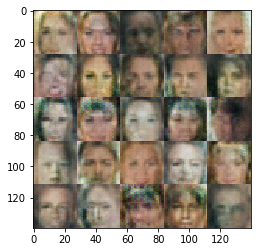

Epoch 1/1... Discriminator Loss: 0.2900... Generator Loss: 1.9075
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 3.3447
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 4.9734
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 6.3102
Epoch 1/1... Discriminator Loss: 0.1400... Generator Loss: 3.1192
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 9.4749
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 8.1462


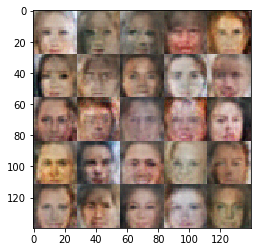

Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 10.6371
Epoch 1/1... Discriminator Loss: 0.1631... Generator Loss: 2.7542
Epoch 1/1... Discriminator Loss: 0.2365... Generator Loss: 2.3251
Epoch 1/1... Discriminator Loss: 1.7570... Generator Loss: 5.7809
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 3.8333
Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 4.3243
Epoch 1/1... Discriminator Loss: 0.2325... Generator Loss: 1.9602
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 5.4407
Epoch 1/1... Discriminator Loss: 0.0739... Generator Loss: 8.1391


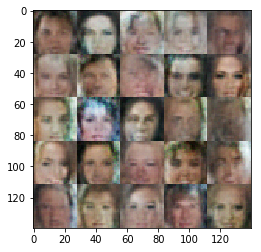

Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 5.1437
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.7185
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 8.9389
Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 7.7769
Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 3.6306
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 8.5538
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 8.1188
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 5.5438
Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 9.1118
Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 8.8505


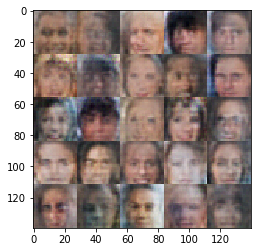

Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 4.7491
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 2.1354
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.7418
Epoch 1/1... Discriminator Loss: 0.1529... Generator Loss: 2.8396
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 5.2788
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 7.5463
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 0.0286... Generator Loss: 8.0537


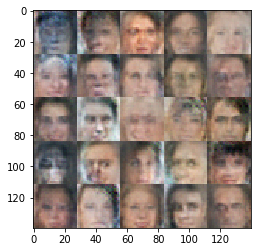

Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 6.1284
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 6.0745
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 3.9914
Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 2.3472
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 7.6490
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 7.9927
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 0.1982... Generator Loss: 10.2145
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 10.1912
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.3457


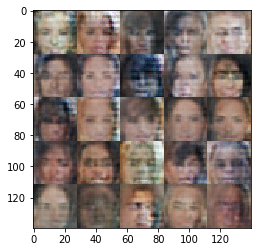

Epoch 1/1... Discriminator Loss: 0.2679... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.0350... Generator Loss: 8.4198
Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 3.0392
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 4.8128
Epoch 1/1... Discriminator Loss: 0.0426... Generator Loss: 7.6138
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 7.5553
Epoch 1/1... Discriminator Loss: 0.2354... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 3.6474
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 6.2660


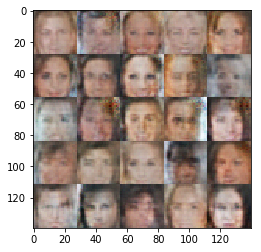

Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 8.9807
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 2.5740
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 7.4443
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 6.5698
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 8.5077
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 4.0062
Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 8.5913


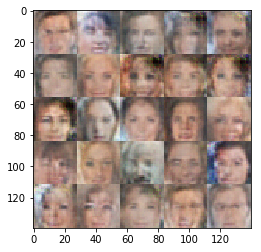

Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 5.6462
Epoch 1/1... Discriminator Loss: 0.3192... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 8.6258
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 4.4847
Epoch 1/1... Discriminator Loss: 0.1330... Generator Loss: 4.8208
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 2.5864
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 0.1277... Generator Loss: 2.7396
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 7.3548
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 4.2400


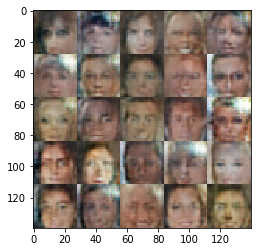

Epoch 1/1... Discriminator Loss: 0.2507... Generator Loss: 9.0631
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 8.6104
Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 2.0935
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 0.0353... Generator Loss: 5.4748
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 2.1881... Generator Loss: 0.1610
Epoch 1/1... Discriminator Loss: 0.2698... Generator Loss: 2.3831
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 6.8293


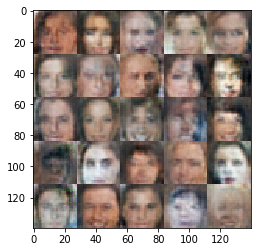

Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 4.5668
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 8.5560
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 3.4526
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 4.4954
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 1.9131
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.6218
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 5.1824
Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 2.3213


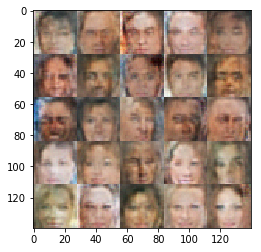

Epoch 1/1... Discriminator Loss: 0.2436... Generator Loss: 7.6316
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 2.7277
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 4.1539
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 4.1624
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 6.2459
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 6.5063
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 7.9680
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 4.2765


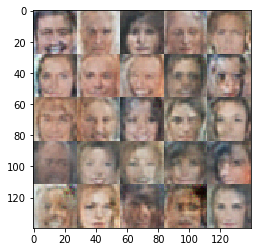

Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 6.8542
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 5.5441
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 6.5480
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 6.2733
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 5.7066
Epoch 1/1... Discriminator Loss: 0.1323... Generator Loss: 3.2411
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 4.9100
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 1.9598
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 10.2074
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 5.2961


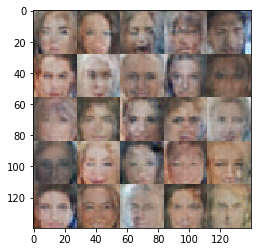

Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 6.6491
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 5.8151
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 1.7008
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 4.5653
Epoch 1/1... Discriminator Loss: 0.1220... Generator Loss: 7.3574
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 4.6340
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 9.3863
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 5.0778
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 5.0956


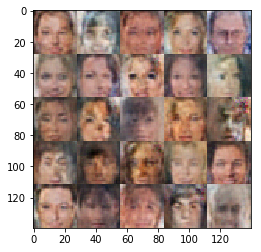

Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 6.1406
Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 4.9259
Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 8.7657
Epoch 1/1... Discriminator Loss: 0.0668... Generator Loss: 5.8213
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 8.0221
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 2.5008
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 5.9018
Epoch 1/1... Discriminator Loss: 0.2693... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 2.9793
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 2.0506


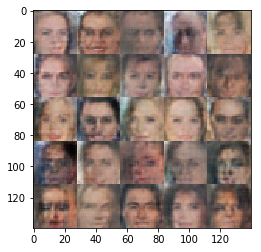

Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 5.3972
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 3.0683
Epoch 1/1... Discriminator Loss: 0.0953... Generator Loss: 7.4777
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 5.7554
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 6.8241
Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 7.2031
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 8.3245
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 3.6975


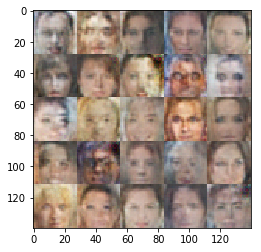

Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 4.1643
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 10.1540
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.8281
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 3.9655
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 8.3006
Epoch 1/1... Discriminator Loss: 0.2278... Generator Loss: 1.9281


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.